In [1]:
import torch
from torch import nn
from torchmetrics import F1Score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import ipaddress

/home/ivo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/ivo/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

# Botnet Detection
## A Multiclass Classification Problem

### About The Dataset

The dataset can be found [zenodo.org/records/8035724](https://zenodo.org/records/8035724)

In the research paper [An empirical comparison of botnet detection methods](https://doi.org/10.1016/j.cose.2014.05.011) we have some information on the features used.
1. Source IP address
2. Amount of unique source ports used by this source IP address.
3. Amount of unique destination IP addresses contacted by this source IP address.
4. Amount of unique destination ports contacted by this source IP address.
5. Amount of NetFlows used by this source IP address.
6. Amount of bytes transferred by this source IP address.
7. Amount of packets transferred by this source IP address.

After clustering some of this observations, the authors created some more features:
1. Total amount of instances in the cluster.
2. Total amount of NetFlows in the cluster.
3. Amount of source IP addresses.
4. Average amount of unique source ports.
5. Standard Deviation of the amount of unique source ports.
6. Average amount of unique destination IP addresses.
7. Standard Deviation of the amount of unique destination IP addresses.
8. Average amount of unique destination ports.
9. Standard Deviation of the amount of unique destination ports.
10. Average amount of NetFlows.
11. Standard Deviation of the amount of NetFlows.
12. Average amount of bytes transferred.
13. Standard Deviation of the amount of bytes transferred.
14. Average amount of packets transferred.
15. Standard Deviation of the amount of packets transferred.

The remaining features should be self-explanatory.

### Importing Data

In [3]:
raw_data = pd.read_csv("./data/botnet_multiclass.csv")

In [4]:
raw_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176640 entries, 0 to 176639
Columns: 85 entries, Unnamed: 0.1 to LABEL
dtypes: bool(4), float64(61), int64(17), object(3)
memory usage: 109.8+ MB


In [5]:
(raw_data.isna()).any().any() # True means that we have missing data

True

We need to transform the object columns, and deal with missing data.

### Preprocessing The Data

In [6]:
preprocessed_data = raw_data.copy(deep=True) 
# since we have enough memory, it should be ok. This will avoid messing the original data.


In [7]:
object_columns = preprocessed_data.select_dtypes(include=['object'])
object_columns.columns


Index(['DST_IP', 'SRC_IP', 'LABEL'], dtype='object')

Let's encode the destination and source IP.

In [8]:
object_columns[['DST_IP', 'SRC_IP']].head()
# notice row with index 3. There's an extra final "."

,DST_IP,SRC_IP
0,147.32.80.9,147.32.84.165
1,147.32.84.255,147.32.84.165
2,147.32.84.255,147.32.84.165
3,147.32.84.165.,60.190.222.139
4,60.190.222.139.,147.32.84.165


In [9]:
def ip_encoding(ip_address:str) -> int:
    return int(ipaddress.ip_address(ip_address.rstrip(".")))

In [10]:
ipaddress.ip_address(ip_encoding("147.32.84.165."))

IPv4Address('147.32.84.165')

In [11]:
preprocessed_data['DST_IP'] = preprocessed_data['DST_IP'].apply(ip_encoding)
preprocessed_data["SRC_IP"] = preprocessed_data['SRC_IP'].apply(ip_encoding)
preprocessed_data[['DST_IP',"SRC_IP"]].head()

,DST_IP,SRC_IP
0,2468368393,2468369573
1,2468369663,2468369573
2,2468369663,2468369573
3,2468369573,1019141771
4,1019141771,2468369573


In [12]:
label_enc = LabelEncoder()
preprocessed_data["LABEL"] = label_enc.fit_transform(preprocessed_data["LABEL"])

In [13]:
label_enc.classes_

array(['clear', 'donbot', 'fast_flux', 'neris', 'qvod', 'rbot'],
      dtype=object)

The zero class represents 'normalware', whereas all the remaining classes represent some sort of malware, more specifically botnets.

Let's do a small EDA on the classes.

In [14]:
labels_counts = preprocessed_data[["LABEL"]].value_counts()
labels_counts

LABEL
0        165573
3          6332
2          4367
4           286
5            55
1            27
Name: count, dtype: int64

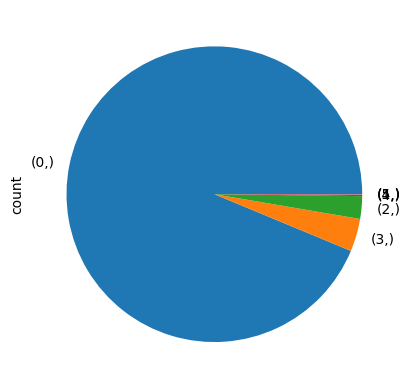

In [15]:
labels_counts.plot.pie(); # type: ignore

Our dataset is highly imbalanced, to the point that classifying some classes could be considered as outlier detection. There will be a section focused on this problem later on.

For now, we will conduct our analysis without worrying to much on the class imbalance problem.

In [16]:
preprocessed_data[preprocessed_data.isna().any(axis=1)].shape
# there are 150598 row whose values have at least an NaN, leaving us with 
# only 26042 rows which are completely filled. Even though torch NN can take NaNs values, 
# these will contaminate the calculations, resulting in predictions full of NaNs. 

(150598, 85)

To keep this notebook simple, I'll just drop the rows with NaN's values.
In a more demanding setting, we should decide on an imputation method for each feature, *separately*. And depending on the chosen method, we may only apply it after we've splitted the data into train and test set.

In [17]:
preprocessed_data = preprocessed_data.dropna()
preprocessed_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 26042 entries, 1 to 176607
Columns: 85 entries, Unnamed: 0.1 to LABEL
dtypes: bool(4), float64(61), int64(20)
memory usage: 16.4 MB


### Splitting The Data

In [18]:
# Separating features and label
X = torch.tensor(preprocessed_data.iloc[:,:-1].values.astype(np.float64), dtype=torch.float64)
# torch complains about a numpy.object_, even though pandas say there's no type object.
# so, I have to use .astype. Also, if we use something less than np.float64, 
# we'll have overflow problems, and torch will put `inf`, and this will create problems.
y = torch.tensor(preprocessed_data["LABEL"].values.astype(np.float64), dtype=torch.float64)
# CrossEntropyLoss expects targets of 0D or 1D.

In [19]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.9, stratify=y)
# stratify will help keep the proportions of the classes in both y_train and y_test,
# and thus avoid having a zero-shot classification problem on our hands.

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([23437, 84]),
 torch.Size([23437]),
 torch.Size([2605, 84]),
 torch.Size([2605]))

Let's check out the distribution of the class labels

In [20]:
pd.DataFrame(y_train.numpy()).value_counts(normalize=True)
# we have all classes in the training set, which is good

0.0    0.764432
3.0    0.177326
2.0    0.049836
4.0    0.007595
5.0    0.000512
1.0    0.000299
Name: proportion, dtype: float64

In [21]:
pd.DataFrame(y_test.numpy()).value_counts(normalize=True)
# we also have all classes in the test set, with the weights of each class being very
# similar. This will avoid problems as distribution shift

0.0    0.764299
3.0    0.177351
2.0    0.049904
4.0    0.007678
1.0    0.000384
5.0    0.000384
Name: proportion, dtype: float64

### Creating The Model

In [22]:
# 1. Construct a model class that subclasses nn.Module
class BotNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.train_loss_values = []
        self.test_loss_values = []
        self.f1 = F1Score(task="multiclass", num_classes=6)
        self.layer_1 = nn.Linear(in_features=84, out_features=30, dtype=torch.float64) 
        self.layer_2 = nn.Linear(in_features=30, out_features=10, dtype=torch.float64)
        self.layer_3 = nn.Linear(in_features=10, out_features=6, dtype=torch.float64)
        # output should have 6 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        return  self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
    def train_loop(self, input: torch.Tensor, labels: torch.Tensor, 
                   loss_fn:nn.modules.loss._Loss, optimizer: torch.optim.Optimizer):
        self.train()
        # Forward pass on train data using the forward() method
        # CrossEntropyLoss works directly with logits as inputs
        logits = self(input)
        # CrossEntropyLoss expects a tensor of type long as targets.
        # if we don't do the type casting outside the loss function, we get an error
        labels_long = labels.to(dtype=torch.long)
        loss = loss_fn(logits, labels_long)
        # return rows with prob like quantities of size 6
        pred = nn.Softmax(dim=1)(logits).argmax(dim=1) 
        f1_value = self.f1(pred, labels)
        # Backpropagation
        loss.backward()
        # optimize parameters
        optimizer.step()
        # restart cycle
        optimizer.zero_grad()
        return loss, f1_value
    
    def test_loop(self, input: torch.Tensor, labels: torch.Tensor, 
                  loss_fn:nn.modules.loss._Loss):
        self.eval()
        with torch.inference_mode():
            logits = self(input)
            labels_long = labels.to(dtype=torch.long)
            loss = loss_fn(logits, labels_long)
            pred = nn.Softmax(dim=1)(logits).argmax(dim=1)
            f1_value = self.f1(pred, labels)
        return loss, f1_value
    
    def train_model(self, input: torch.Tensor, labels: torch.Tensor,
                    loss_fn:nn.modules.loss._Loss, optimizer: torch.optim.Optimizer,
                    n_epochs:int = 100):
        for epoch in range(1,n_epochs+1):
            print(f"Epoch {epoch}\n-------------------------------")
            train_loss, train_f1 = self.train_loop(input = input, labels = labels, 
                                         loss_fn = loss_fn, optimizer = optimizer)
            self.train_loss_values.append(train_loss.detach().cpu().numpy())
            test_loss, test_f1 = self.test_loop(input = input, labels = labels, 
                                       loss_fn = loss_fn)
            self.test_loss_values.append(test_loss.detach().cpu().numpy())
            print(
                f"{loss_fn._get_name()} Train Loss: {train_loss} |"
                f"{loss_fn._get_name()} Test Loss: {test_loss}"
            )
            print(
                f"F1 Train Score: {train_f1}  | F1 Test Score: {test_f1}"
            )
        print("Done!")
    
    def predict(self, input: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.inference_mode():
            logits = self(input)
            pred = nn.Softmax(dim=1)(logits).argmax(dim=1)
        return pred

In [23]:
# 4. Create an instance of the model and send it to target device
botnet_cl = BotNetClassifier().to(device)
botnet_cl

BotNetClassifier(
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=84, out_features=30, bias=True)
  (layer_2): Linear(in_features=30, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=6, bias=True)
  (relu): ReLU()
)

In [24]:
botnet_cl(X_train.to(device)) # simple litmus test to check whether it's working

tensor([[ 16219541.6466, -56927594.1368,  19459940.4476,  56225135.2202,
         -52848711.4474, -26583584.2109],
        [  1527536.4929, -42386992.0813,  17320072.4345,  80144927.6522,
         -43052192.9036, -26483085.4649],
        [ 15529199.4468, -61502061.9916,  20694104.5652,  75803644.7419,
         -69323667.8517, -30827996.1198],
        ...,
        [  3855499.5252, -45977489.3800,  16666083.6515,  76618050.2813,
         -49725501.4039, -26684591.5181],
        [ 16241216.9965, -56837179.4351,  19452177.6533,  56018482.8865,
         -52669402.8578, -26527799.4007],
        [ 16243865.3001, -56836782.5250,  19453129.2123,  56012788.5729,
         -52663968.2991, -26526689.3268]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)

In [25]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=botnet_cl.parameters(), 
                            lr=0.1)


In [26]:
botnet_cl.train_model(input= X_train.to(device), labels=y_train.to(device), 
                      loss_fn=loss_fn, optimizer=optimizer)

Epoch 1
-------------------------------
CrossEntropyLoss Train Loss: 57456232.31010731 |CrossEntropyLoss Test Loss: 3.218310987491218e+30
F1 Train Score: 0.17732645571231842  | F1 Test Score: 0.7644323110580444
Epoch 2
-------------------------------
CrossEntropyLoss Train Loss: 3.218310987491218e+30 |CrossEntropyLoss Test Loss: 346902.8379035307
F1 Train Score: 0.7644323110580444  | F1 Test Score: 0.7644323110580444
Epoch 3
-------------------------------
CrossEntropyLoss Train Loss: 346902.8379035307 |CrossEntropyLoss Test Loss: 1.6184206978328923
F1 Train Score: 0.7644323110580444  | F1 Test Score: 0.7644323110580444
Epoch 4
-------------------------------
CrossEntropyLoss Train Loss: 1.6184206978328923 |CrossEntropyLoss Test Loss: 1.579202141773818
F1 Train Score: 0.7644323110580444  | F1 Test Score: 0.7644323110580444
Epoch 5
-------------------------------
CrossEntropyLoss Train Loss: 1.579202141773818 |CrossEntropyLoss Test Loss: 1.541491755270979
F1 Train Score: 0.7644323110580

CrossEntropyLoss Train Loss: 0.9933808199852118 |CrossEntropyLoss Test Loss: 0.9838470745863791
F1 Train Score: 0.7644323110580444  | F1 Test Score: 0.7644323110580444
Epoch 33
-------------------------------
CrossEntropyLoss Train Loss: 0.9838470745863791 |CrossEntropyLoss Test Loss: 0.9748128468739633
F1 Train Score: 0.7644323110580444  | F1 Test Score: 0.7644323110580444
Epoch 34
-------------------------------
CrossEntropyLoss Train Loss: 0.9748128468739633 |CrossEntropyLoss Test Loss: 0.9662493308536151
F1 Train Score: 0.7644323110580444  | F1 Test Score: 0.7644323110580444
Epoch 35
-------------------------------
CrossEntropyLoss Train Loss: 0.9662493308536151 |CrossEntropyLoss Test Loss: 0.9581292239024459
F1 Train Score: 0.7644323110580444  | F1 Test Score: 0.7644323110580444
Epoch 36
-------------------------------
CrossEntropyLoss Train Loss: 0.9581292239024459 |CrossEntropyLoss Test Loss: 0.9504266839020291
F1 Train Score: 0.7644323110580444  | F1 Test Score: 0.7644323110580

If we look at the F1 score, and Loss, we'll see that they are very similar, if not equal, on both train and test set. This is odd...

In [27]:
botnet_predictions = botnet_cl.predict(X_test.to(device))
pd.DataFrame(botnet_predictions.cpu().numpy()).value_counts()

0    2605
Name: count, dtype: int64

As expected, due to the imbalanced dataset, the botnet_cl decided to classify all test observations as 'normalware'.

### Dealing with Imbalance

#### Possible Avenues

The following are some common approaches to address class imbalance in multi-class classification:

**Resampling Techniques**:
- Oversampling, or creating synthetic samples of the minority classes(e.g. SMOTE or ADASYN). This may lead to addition of noise.
- Undersampling the instances in the majority class. This may lead to loss of crucial information.
We may try to use [imbalanced-learn](https://imbalanced-learn.org/stable/index.html)

**Weighted Loss Function**:
We can give more importance to minority classes during training, by tweeking the weight parameter in the `torch.nn.CrossEntropyLoss`` function. I've experimented this, and in an isolated manner, it's not sufficient.

**Ensemble Methods**:
Ensemble methods (bagging, boosting, stacking, voting, or weighted avg), can improve performance on imbalance datasets. Maybe trying [Ensemble-PyTorch](https://ensemble-pytorch.readthedocs.io/en/latest/index.html)

**Anomaly Detection**:
Treat the minority classes as an anomaly/outlier detection problem.

**Data Augmentation**:
Augment the minority class data by applying various data augmentation techniques such as rotation, scaling, or adding noise. This can increase the diversity of the minority class samples.

**Transfer Learning**:
Utilize pre-trained models and fine-tune them on your imbalanced dataset. Transfer learning can be especially useful when you have limited data for the minority classes.

**Combine Classes**:
Merge similar classes to reduce the number of classes, making the problem more balanced.
Well, we could merge all malware classes into one, and transform this into a binary classification problem.

**Evaluate Performance Metrics**:
Instead of using accuracy as the sole performance metric, consider using metrics like precision, recall, F1-score, or area under the ROC curve (AUC) that provide a better understanding of the model's performance on imbalanced data.
